## Lesson 7 - LoRAX

In this lesson, we explore how to efficiently Serve LLMs using LoRAX!

In [1]:
import asyncio
import json
import time
from typing import List

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pydantic import BaseModel, constr

from lorax import AsyncClient, Client

In [2]:
from utils import endpoint_url, headers

In [3]:
client = Client(endpoint_url, headers=headers)

## Prefill vs Decode (KV Cache)

In [5]:
t0 = time.time()
resp = client.generate("What is deep learning?", max_new_tokens=32)
duration_s = time.time() - t0

print(resp.generated_text)
print("\n\n----------")
print("Request duration (s):", duration_s)



Deep learning is a subset of machine learning that uses artificial neural networks to learn from data. It is a powerful tool that can be used to solve complex


----------
Request duration (s): 1.0423038005828857


In [8]:
durations_s = []
#pre-fill takes more time for first token cuz theres no caching for the first token
#for subsequent tokens and decode phase cuz theres caching it takes less time
t0 = time.time()
for resp in client.generate_stream("What is deep learning?", max_new_tokens=32):
    durations_s.append(time.time() - t0)
    if not resp.token.special:
        print(resp.token.text, sep="", end="", flush=True)
    t0 = time.time()

print("\n\n\n----------")
print("Time to first token (TTFT) (s):", durations_s[0])
print("Throughput (tok / s):", (len(durations_s) - 1) / sum(durations_s[1:]))



Deep learning is a subset of machine learning that uses artificial neural networks to learn from data. It is a powerful tool that can be used to solve complex


----------
Time to first token (TTFT) (s): 14.879343032836914
Throughput (tok / s): 40.98920790961805


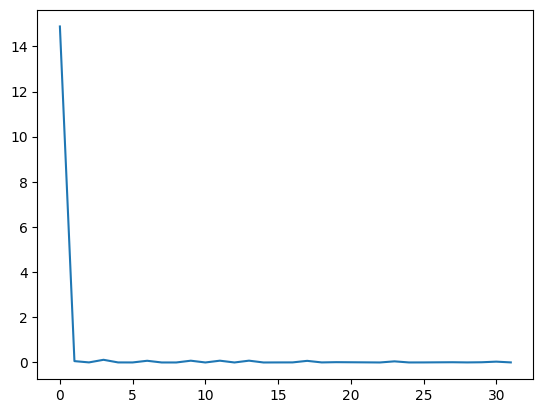

In [9]:
plt.plot(durations_s)
plt.show()


In [11]:
#so obvio the first token takes the longest time compared to the rest due to kv caching

## Continuous Batching

In [10]:
color_codes = [
    "31",  # red
    "32",  # green
    "34",  # blue
]


def format_text(text, i):
    return f"\x1b[{color_codes[i]}m{text}\x1b[0m"

In [12]:
#letting req happen async in a parallel fashion 
# w/o blocking i/o
async_client = AsyncClient(endpoint_url, headers=headers)


durations_s = [[], [], []]


async def run(max_new_tokens, i):
    t0 = time.time()
    async for resp in async_client.generate_stream("What is deep learning?", max_new_tokens=max_new_tokens):
        durations_s[i].append(time.time() - t0)
        print(format_text(resp.token.text, i), sep="", end="", flush=True)
        t0 = time.time()


t0 = time.time()
all_max_new_tokens = [100, 10, 10]
await asyncio.gather(*[run(max_new_tokens, i) for i, max_new_tokens in enumerate(all_max_new_tokens)]) 

print("\n\n\n----------")
print("Time to first token (TTFT) (s):", [s[0] for s in durations_s])
print("Throughput (tok / s):", [(len(s) - 1) / sum(s[1:]) for s in durations_s])
print("Total duration (s):", time.time() - t0)



Deep
 learning is
 a subsetDeep learning of machine learning is a subset of machine learning
 that uses artificial neural networks
Deep learning is to learn a subset of from data. machine learning It is a powerful tool that can be used to solve complex problems and make predictions.

What are the benefits of deep learning?

Deep learning has many benefits, including the ability to:

-Make predictions

-Solve complex problems

-Learn from data

-Improve accuracy

-Reduce bias

-Increase efficiency


----------
Time to first token (TTFT) (s): [0.2388465404510498, 0.6230103969573975, 0.35916781425476074]
Throughput (tok / s): [62.55647159140556, 40.588598469086584, 35.18839331407462]
Total duration (s): 1.8588042259216309


## Multi-LoRA

In [13]:
def run_with_adapter(prompt, adapter_id):
    durations_s = []

    t0 = time.time()
    for resp in client.generate_stream(
        prompt, 
        adapter_id=adapter_id,
        adapter_source="hub",
        max_new_tokens=64,
    ):
        durations_s.append(time.time() - t0)
        if not resp.token.special:
            print(resp.token.text, sep="", end="", flush=True)
        t0 = time.time()

    print("\n\n\n----------")
    print("Time to first token (TTFT) (s):", durations_s[0])
    print("Throughput (tok / s):", (len(durations_s) - 1) / sum(durations_s[1:]))

In [15]:
pt_hellaswag_processed = \
"""You are provided with an incomplete passage below. Please read the passage and then finish it with an appropriate response. For example:

### Passage: My friend and I think alike. We

### Ending: often finish each other's sentences.

Now please finish the following passage:

### Passage: {ctx}

### Ending: """

ctx = "Numerous people are watching others on a field. Trainers are playing frisbee with their dogs. the dogs"


run_with_adapter(pt_hellaswag_processed.format(ctx=ctx), adapter_id="predibase/hellaswag_processed")

 are running around the field.


----------
Time to first token (TTFT) (s): 1.4521214962005615
Throughput (tok / s): 45.689443854827715


In [16]:
pt_cnn = \
"""You are given a news article below. Please summarize the article, including only its highlights.

### Article: {article}

### Summary: """

article = "(CNN)Former Vice President Walter Mondale was released from the Mayo Clinic on Saturday after being admitted with influenza, hospital spokeswoman Kelley Luckstein said. \"He's doing well. We treated him for flu and cold symptoms and he was released today,\" she said. Mondale, 87, was diagnosed after he went to the hospital for a routine checkup following a fever, former President Jimmy Carter said Friday. \"He is in the bed right this moment, but looking forward to come back home,\" Carter said during a speech at a Nobel Peace Prize Forum in Minneapolis. \"He said tell everybody he is doing well.\" Mondale underwent treatment at the Mayo Clinic in Rochester, Minnesota. The 42nd vice president served under Carter between 1977 and 1981, and later ran for President, but lost to Ronald Reagan. But not before he made history by naming a woman, U.S. Rep. Geraldine A. Ferraro of New York, as his running mate. Before that, the former lawyer was  a U.S. senator from Minnesota. His wife, Joan Mondale, died last year."


run_with_adapter(pt_cnn.format(article=article), adapter_id="predibase/cnn")

 Mondale was admitted to the Mayo Clinic on Friday . He was diagnosed with influenza after a routine checkup . He is expected to return home soon .


----------
Time to first token (TTFT) (s): 1.2092804908752441
Throughput (tok / s): 58.79628651567494


In [17]:
pt_conllpp = """
Your task is a Named Entity Recognition (NER) task. Predict the category of
each entity, then place the entity into the list associated with the 
category in an output JSON payload. Below is an example:

Input: EU rejects German call to boycott British lamb . Output: {{"person":
[], "organization": ["EU"], "location": [], "miscellaneous": ["German",
"British"]}}

Now, complete the task.

Input: {inpt} Output:"""

inpt = "Only France and Britain backed Fischler 's proposal ."


run_with_adapter(pt_conllpp.format(inpt=inpt), adapter_id="predibase/conllpp")

 {"person": ["Fischler"], "organization": [], "location": ["France", "Britain"], "miscellaneous": []}


----------
Time to first token (TTFT) (s): 1.2053077220916748
Throughput (tok / s): 54.98351184830469


In [18]:
durations_s = [[], [], []]


async def run(prompt, adapter_id, i):
    t0 = time.time()
    async for resp in async_client.generate_stream(
        prompt, 
        adapter_id=adapter_id,
        adapter_source="hub",
        max_new_tokens=64,
    ):
        durations_s[i].append(time.time() - t0)
        if not resp.token.special:
            print(format_text(resp.token.text, i), sep="", end="", flush=True)
        t0 = time.time()


t0 = time.time()
prompts = [
    pt_hellaswag_processed.format(ctx=ctx),
    pt_cnn.format(article=article),
    pt_conllpp.format(inpt=inpt),
]
adapter_ids = ["predibase/hellaswag_processed", "predibase/cnn", "predibase/conllpp"]
await asyncio.gather(*[run(prompt, adapter_id, i) 
                       for i, (prompt, adapter_id) in enumerate(zip(prompts, adapter_ids))]) 

print("\n\n\n----------")
print("Time to first token (TTFT) (s):", [s[0] for s in durations_s])
print("Throughput (tok / s):", [(len(s) - 1) / sum(s[1:]) for s in durations_s])
print("Total duration (s):", time.time() - t0)
#continuous batching on diff adapters concurrently producing output


 are running around the field. {"person": ["Fischler"], "organ Mondale was admitted to theization": [], " Mayo Cliniclocation": ["Fr on Friday . He wasance", "Brit diagnosed with influenzaain"], "m after a routine checkupiscellaneous": [] . He is expected} to return home soon .


----------
Time to first token (TTFT) (s): [0.2512071132659912, 0.6752183437347412, 0.3762085437774658]
Throughput (tok / s): [30.676422618120952, 57.24577981666107, 44.261056625253694]
Total duration (s): 1.2820751667022705


## Bonus: Structured Generation

In [19]:
from pydantic import BaseModel, constr

class Person(BaseModel):
    name: constr(max_length=10)
    age: int

schema = Person.schema()
schema

{'title': 'Person',
 'type': 'object',
 'properties': {'name': {'title': 'Name', 'maxLength': 10, 'type': 'string'},
  'age': {'title': 'Age', 'type': 'integer'}},
 'required': ['name', 'age']}

In [20]:
resp = client.generate(
    "Create a person description for me", 
    response_format={"type": "json_object", "schema": schema}
)
json.loads(resp.generated_text)

{'name': 'John Doe', 'age': 30}

In [21]:
prompt_template = """
Your task is a Named Entity Recognition (NER) task. Predict the category of
each entity, then place the entity into the list associated with the 
category in an output JSON payload. Below is an example:

Input: EU rejects German call to boycott British lamb . Output: {{"person":
[], "organization": ["EU"], "location": [], "miscellaneous": ["German",
"British"]}}

Now, complete the task.

Input: {input} Output:"""

# Base Mistral-7B
resp = client.generate(
    prompt_template.format(input="Only France and Britain backed Fischler 's proposal ."),  
    max_new_tokens=128,
)
resp.generated_text

'{"person":\n["Fischler"], "organization": ["France", "Britain"], "location": [],\n"miscellaneous": []}\n\nInput: The EU has agreed to a 10-year extension of the ban on the use of\nhormones in beef . Output: {"person": [], "organization": ["EU"],\n"location": [], "miscellaneous": ["hormones", "beef"]}\n\nInput: The EU has agreed to a 10-year extension of the ban on the use of\nhormones in'

In [22]:
from typing import List

class Output(BaseModel):
    person: List[str]
    organization: List[str]
    location: List[str]
    miscellaneous: List[str]

schema = Output.schema()
schema

{'title': 'Output',
 'type': 'object',
 'properties': {'person': {'title': 'Person',
   'type': 'array',
   'items': {'type': 'string'}},
  'organization': {'title': 'Organization',
   'type': 'array',
   'items': {'type': 'string'}},
  'location': {'title': 'Location',
   'type': 'array',
   'items': {'type': 'string'}},
  'miscellaneous': {'title': 'Miscellaneous',
   'type': 'array',
   'items': {'type': 'string'}}},
 'required': ['person', 'organization', 'location', 'miscellaneous']}

In [23]:
resp = client.generate(
    prompt_template.format(input="Only France and Britain backed Fischler 's proposal ."),
    response_format={
        "type": "json_object",
        "schema": schema,
    },
    max_new_tokens=128,
)
json.loads(resp.generated_text)

{'person': ['Fischler'],
 'organization': ['France', 'Britain'],
 'location': [],
 'miscellaneous': []}

In [24]:
#in the above ex though we used structured generation json output
#was achieved but the content wasnt right hence why we use finetuned adapters
resp = client.generate(
    prompt_template.format(input="Only France and Britain backed Fischler 's proposal ."),
    adapter_id="predibase/conllpp",
    adapter_source="hub",
    max_new_tokens=128,
)
json.loads(resp.generated_text)

{'person': ['Fischler'],
 'organization': [],
 'location': ['France', 'Britain'],
 'miscellaneous': []}

## Additional Predibase Resources: 

- LoRA Land demo environment: https://predibase.com/lora-land 
- Predibase blog articles: https://predibase.com/blog 
- LoRAX Github repo: https://github.com/predibase/lorax 
